In [19]:
# Core
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
import pandas as pd
import numpy as np
import os
import gc
import re
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob
import warnings
from IPython import display as ipd
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib.patches import Rectangle
import seaborn as sns
import random
from joblib import Parallel, delayed
import os, shutil
import datetime 
import holidays
import dateutil.easter as easter

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,SGDRegressor
from sklearn.model_selection import StratifiedGroupKFold


from matplotlib import pyplot




## Import the Dataset

In [20]:
train_df = pd.read_csv("../data/train.csv", parse_dates=['date'])
original_train_df = train_df.copy()
test_df = pd.read_csv('../data/test.csv', parse_dates=['date'])
train_df.head()


,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [21]:
df_gdp = pd.read_csv("../data/GDP_data_2017_to_2021.csv")
df_gdp_all = df_gdp.groupby('year')['GDP'].sum().reset_index()

In [22]:
for df in [train_df, test_df]:
    df['product'] = df['product'].str.replace(' ', '_')
    df['product'] = df['product'].str.replace(':', '_')

In [23]:
test_df.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle_Advanced_Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle_Getting_Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle_Recipe_Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle_for_Kids__One_Smart_Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle_Advanced_Techniques


## Explore the Dataset

In [24]:
product_df = train_df.groupby(["date","product"])["num_sold"].sum().reset_index()
product_df.head()

,date,product,num_sold
0,2017-01-01,Kaggle_Advanced_Techniques,4267
1,2017-01-01,Kaggle_Getting_Started,3492
2,2017-01-01,Kaggle_Recipe_Book,2900
3,2017-01-01,Kaggle_for_Kids__One_Smart_Goose,4693
4,2017-01-02,Kaggle_Advanced_Techniques,3242


In [25]:
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()
product_ratio_df.head(4)

,date,product,ratios
0,2017-01-01,Kaggle_Advanced_Techniques,0.277944
1,2017-01-01,Kaggle_Getting_Started,0.227462
2,2017-01-01,Kaggle_Recipe_Book,0.188900
3,2017-01-01,Kaggle_for_Kids__One_Smart_Goose,0.305693


In [26]:
product_ratio_df.tail()

,date,product,ratios
5839,2020-12-30,Kaggle_for_Kids__One_Smart_Goose,0.300929
5840,2020-12-31,Kaggle_Advanced_Techniques,0.291703
5841,2020-12-31,Kaggle_Getting_Started,0.221948
5842,2020-12-31,Kaggle_Recipe_Book,0.193823
5843,2020-12-31,Kaggle_for_Kids__One_Smart_Goose,0.292525


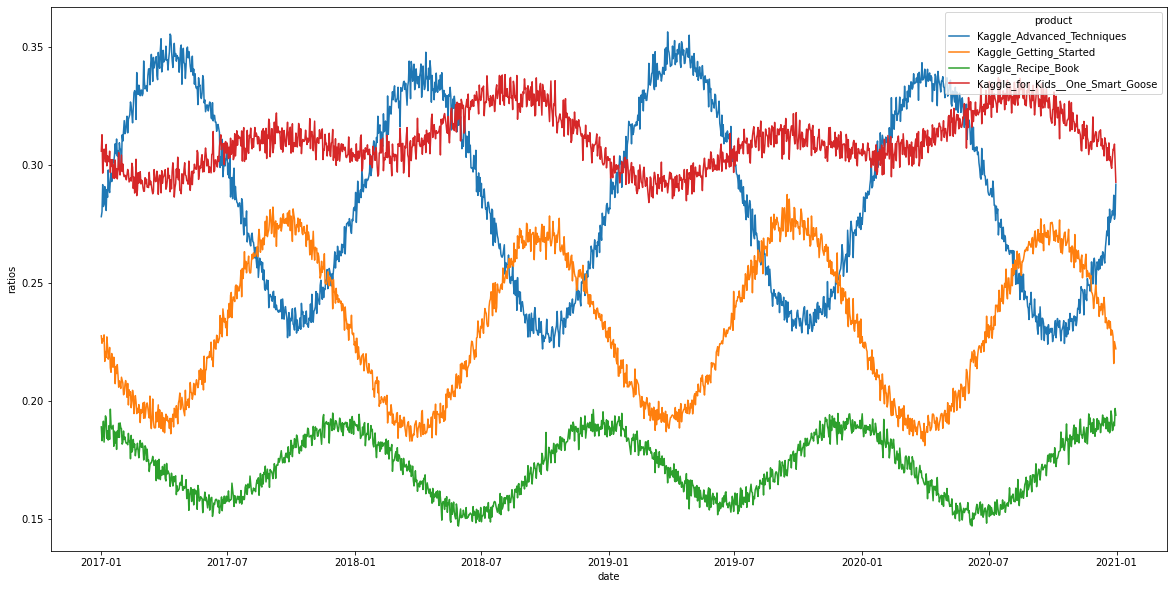

In [27]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = product_ratio_df, x="date", y="ratios", hue="product");

## Train and Aggregated Dataset

In [28]:
train_df = train_df.groupby(["date"])["num_sold"].sum().reset_index()

In [29]:
weekly_df = train_df.groupby([pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train_df.groupby([pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

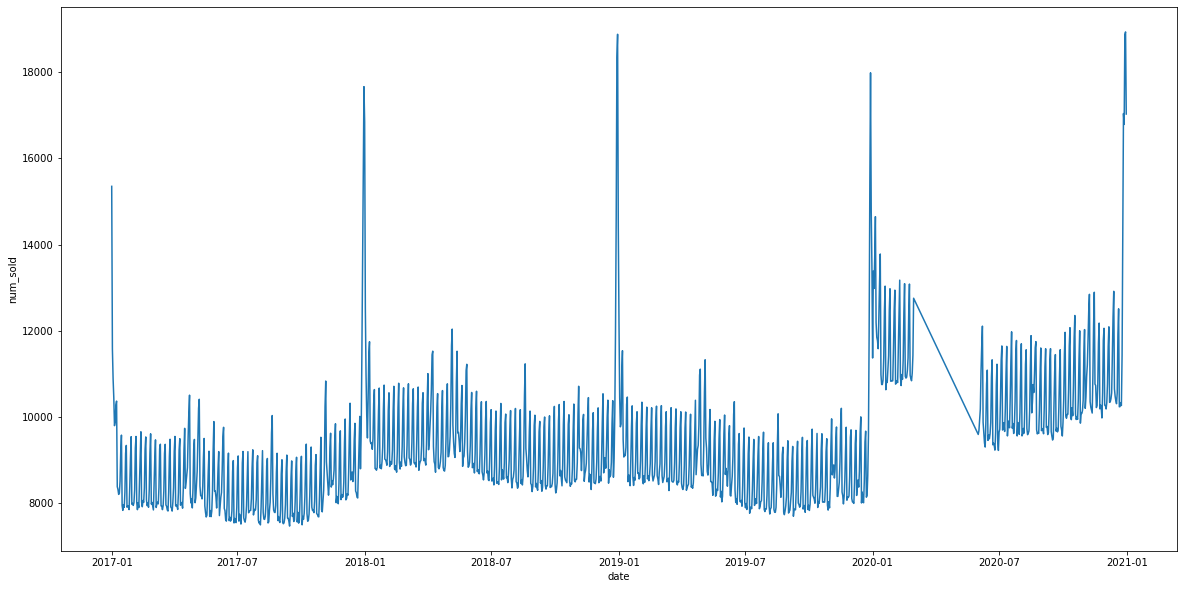

In [30]:
train_nocovid_df = train_df.loc[~((train_df["date"] >= "2020-03-01") & (train_df["date"] < "2020-06-01"))]
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_nocovid_df, x="date", y="num_sold");

In [31]:
train_df = train_nocovid_df

#get the dates to forecast for
test_all_df = test_df.groupby(["date"])["row_id"].first().reset_index().drop(columns="row_id")
#keep dates for later
test_all_df_dates = test_all_df[["date"]]

In [32]:
# https://www.kaggle.com/competitions/optiver-realized-volatility-prediction/discussion/278588

In [33]:
def feature_engineer(df):
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
    #new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    new_df["day"] = df["date"].dt.day
    new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 12))
    #new_df["day_cos"] = np.cos(new_df['day'] * (2 * np.pi / 12))
    
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear

    new_df["day_of_year"] = new_df.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
    
    important_dates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 124, 125, 126, 127, 140, 141, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 
                       180, 181, 203, 230, 231, 232, 233, 234, 282, 289, 290, 307, 308, 309, 310, 311, 312, 313, 317, 318, 319, 320, 360, 361, 362, 363, 364, 365]
    

    new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in important_dates else 0)
    #new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in [1,2,3,4,5,6,7,8,125,126,360,361,362,363,364,365] else 0)
    
    
    new_df["year"] = df["date"].dt.year
    #new_df['is_pandemic_year'] = new_df['year'].astype(int) >= 2020
    '''
    easter_date = new_df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"easter{d}": 
                                      (df.date - easter_date == np.timedelta64(d, "D"))
                                      for d in list(range(-2, 11)) + list(range(40, 48)) + list(range(51, 58))})],
                       axis=1)
    '''
    
    easter_date = new_df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    for day in list(range(-5, 5)) + list(range(40, 48)):
        new_df[f'easter_{day}'] = (new_df.date - easter_date).dt.days.eq(day)
    new_df = new_df.drop(columns=["date","month","day", "day_of_year"])
    
    for col in new_df.columns :
        if 'easter' in col :
            new_df = pd.get_dummies(new_df, columns = [col], drop_first=True)
    
    new_df = pd.get_dummies(new_df, columns = ["important_dates","day_of_week"], drop_first=True)
    
    return new_df

In [34]:
def get_holidays(df):
    years_list = [2017, 2018, 2019, 2020, 2021]

    holiday_BE = holidays.CountryHoliday('BE', years = years_list)
    holiday_FR = holidays.CountryHoliday('FR', years = years_list)
    holiday_DE = holidays.CountryHoliday('DE', years = years_list)
    holiday_IT = holidays.CountryHoliday('IT', years = years_list)
    holiday_PL = holidays.CountryHoliday('PL', years = years_list)
    holiday_ES = holidays.CountryHoliday('ES', years = years_list)

    holiday_dict = holiday_BE.copy()
    holiday_dict.update(holiday_FR)
    holiday_dict.update(holiday_DE)
    holiday_dict.update(holiday_IT)
    holiday_dict.update(holiday_PL)
    holiday_dict.update(holiday_ES)

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
    return df

In [35]:
def encode_holiday_names(df, enc, subset='train'):
    if subset=='train':
        df['holiday_name'] = enc.fit_transform(df['holiday_name'].values.reshape(-1,1))
    else:
        df['holiday_name'] = enc.transform(df['holiday_name'].values.reshape(-1,1))
        not_hol_val = oe.transform([['Not Holiday']])[0,0]
        df.loc[df['holiday_name']==-1, 'holiday_name'] = not_hol_val
    return df

In [36]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [37]:
train_all_df = get_holidays(train_df)
test_all_df = get_holidays(test_all_df)

In [38]:
train_all_df = feature_engineer(train_all_df)
test_all_df = feature_engineer(test_all_df)

In [39]:
train_all_df = encode_holiday_names(train_all_df, oe)
test_all_df = encode_holiday_names(test_all_df, oe)

In [40]:
# Add GDP Feature
#train_all_df = train_all_df.merge(df_gdp_all, left_on=['year'], right_on=['year'], how='left')
#test_all_df = test_all_df.merge(df_gdp_all, left_on=['year'], right_on=['year'], how='left')

In [41]:
#train_all_df.loc[train_all_df[(train_all_df['is_pandemic_year'] == False)]['is_pandemic_year'].index, 'is_pandemic_year'] = 0
#train_all_df.loc[train_all_df[(train_all_df['is_pandemic_year'] == True)]['is_pandemic_year'].index, 'is_pandemic_year'] = 1
#test_all_df.loc[test_all_df[(test_all_df['is_pandemic_year'] == True)]['is_pandemic_year'].index, 'is_pandemic_year'] = 1
#test_all_df.loc[test_all_df[(test_all_df['is_pandemic_year'] == True)]['is_pandemic_year'].index, 'is_pandemic_year'] = 1
#train_all_df['is_pandemic_year'] = train_all_df['is_pandemic_year'].astype('uint')
#test_all_df['is_pandemic_year'] = test_all_df['is_pandemic_year'].astype('uint')

In [42]:
display(train_all_df.head(2))
display(test_all_df.head(2))

,num_sold,holiday_name,is_holiday,month_sin,day_sin,year,easter_-5_True,easter_-4_True,easter_-3_True,easter_-2_True,...,important_dates_320,important_dates_360,important_dates_361,important_dates_362,important_dates_363,important_dates_364,important_dates_365,day_of_week_1,day_of_week_2,day_of_week_3
0,15352,26.0,1,0.5,0.500000,2017,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,11578,3.0,1,0.5,0.866025,2017,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,holiday_name,is_holiday,month_sin,day_sin,year,easter_-5_True,easter_-4_True,easter_-3_True,easter_-2_True,easter_-1_True,...,important_dates_320,important_dates_360,important_dates_361,important_dates_362,important_dates_363,important_dates_364,important_dates_365,day_of_week_1,day_of_week_2,day_of_week_3
0,2.0,1,0.5,0.500000,2021,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,19.0,0,0.5,0.866025,2021,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [43]:
y = train_all_df["num_sold"]
X = train_all_df.drop(columns="num_sold")
X_test = test_all_df

In [44]:
def smape(y_true, y_pred):
    smape = abs(y_true - y_pred) / (abs(y_true) + abs(y_pred))
    smape = smape.mean() * 200
    return smape

In [45]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

In [46]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
linear_preds = linear_model.predict(x_test)

ridge_model = Ridge(tol=1e-2, max_iter=1000000, random_state=42)
ridge_model.fit(x_train, y_train)
ridge_preds = ridge_model.predict(x_test)

lasso_model = Lasso(tol=1e-2, max_iter=1000000, random_state=42)
lasso_model.fit(x_train, y_train)
lasso_preds = lasso_model.predict(x_test)

electic_model = ElasticNet(alpha=0.01, l1_ratio=0.01, random_state=42)
electic_model.fit(x_train, y_train)
electic_preds = electic_model.predict(x_test)

print('lr_pre : ',smape(y_test,linear_preds))
print('ridge_pre : ',smape(y_test,ridge_preds))
print('lasso_pre : ',smape(y_test,lasso_preds))
print('electic_pre : ',smape(y_test,electic_preds))

lr_pre :  5.60637395132961
ridge_pre :  5.662609957912986
lasso_pre :  5.664303410822102
electic_pre :  6.036750238587723


In [47]:
'''
ridge_params = {'alpha' :  0.0001 * np.arange(1, 1000)}
grid = GridSearchCV(estimator = ridge_model, param_grid = ridge_params, scoring = 'neg_mean_absolute_error')

grid.fit(X, y)
best_param = grid.best_params_
print(best_param)
'''

"\nridge_params = {'alpha' :  0.0001 * np.arange(1, 1000)}\ngrid = GridSearchCV(estimator = ridge_model, param_grid = ridge_params, scoring = 'neg_mean_absolute_error')\n\ngrid.fit(X, y)\nbest_param = grid.best_params_\nprint(best_param)\n"

In [48]:
ridge_model2 = Ridge(alpha=0.0999, tol=1e-2, max_iter=1000000, random_state=42)
ridge_model2.fit(x_train, y_train)
ridge_preds2 = ridge_model2.predict(x_test)
print('ridge_pre2 : ',smape(y_test,ridge_preds2))

ridge_pre2 :  5.598929209281578


In [49]:
'''
lasso_params = {'alpha' :  0.0001 * np.arange(1, 1000) }
grid = GridSearchCV(estimator = lasso_model, param_grid = lasso_params, scoring = 'neg_mean_absolute_error')

grid.fit(X, y)
best_param = grid.best_params_
print(best_param)
'''

"\nlasso_params = {'alpha' :  0.0001 * np.arange(1, 1000) }\ngrid = GridSearchCV(estimator = lasso_model, param_grid = lasso_params, scoring = 'neg_mean_absolute_error')\n\ngrid.fit(X, y)\nbest_param = grid.best_params_\nprint(best_param)\n"

In [50]:
lasso_model2 = Lasso(alpha=0.0099, tol=1e-2, max_iter=1000000, random_state=42)
lasso_model2.fit(x_train, y_train)
lasso_preds2 = lasso_model2.predict(x_test)
print('ridge_pre2 : ',smape(y_test,lasso_preds2))

ridge_pre2 :  5.606329926038623


In [51]:
'''
electic_param = {
     'alpha': 0.0001 * np.arange(1, 100),
     'l1_ratio': 0.001 * np.arange(1, 10)}

grid = GridSearchCV(estimator = electic_model, param_grid = electic_param, scoring = 'neg_mean_absolute_error')
    
grid.fit(X, y)
best_param = grid.best_params_
print(best_param)
'''

"\nelectic_param = {\n     'alpha': 0.0001 * np.arange(1, 100),\n     'l1_ratio': 0.001 * np.arange(1, 10)}\n\ngrid = GridSearchCV(estimator = electic_model, param_grid = electic_param, scoring = 'neg_mean_absolute_error')\n    \ngrid.fit(X, y)\nbest_param = grid.best_params_\nprint(best_param)\n"

In [52]:
elastic_model2 = ElasticNet(alpha=0.0002, l1_ratio=0.001, random_state=42)
elastic_model2.fit(x_train, y_train)
elastic_preds2 = elastic_model2.predict(x_test)
print('elastic_pre2 : ',smape(y_test,elastic_preds2))

elastic_pre2 :  5.600117361570827


### Linear Regression(Kfold)

In [53]:
linear_preds = np.zeros(X_test.shape[0])
avg_smape = 0
n=0

kf = GroupKFold(n_splits=4)

for trn_idx, test_idx in kf.split(X, groups=X.year) :
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = y.iloc[trn_idx], y.iloc[test_idx]
    
    linear_model = LinearRegression()
    #linear_model = make_pipeline(StandardScaler(), linear_model)
    linear_model.fit(x_train, y_train)

    y_pred = linear_model.predict(x_valid)
    avg_smape += smape(y_pred, y_valid)

    n = n + 1

    test_pred = linear_model.predict(X_test)
    pred = pd.Series(test_pred) 

    linear_preds += pred / kf.n_splits  
    
print(f"smape: {avg_smape/kf.n_splits}")

smape: 9.90386179924634


### Ridge(Kfold)

In [54]:
ridge_preds = np.zeros(X_test.shape[0])
avg_smape = 0
n=0

kf = GroupKFold(n_splits=4)

for trn_idx, test_idx in kf.split(X, groups=X.year) :
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = y.iloc[trn_idx], y.iloc[test_idx]
    
    ridge_model = Ridge(alpha=0.0999, tol=1e-2, max_iter=1000000, random_state=0)
    #ridge_model = make_pipeline(StandardScaler(), ridge_model)
    ridge_model.fit(x_train, y_train)

    y_pred = ridge_model.predict(x_valid)
    avg_smape += smape(y_pred, y_valid)

    n = n + 1

    test_pred = ridge_model.predict(X_test)
    pred = pd.Series(test_pred) 

    ridge_preds += pred / kf.n_splits  
    
print(f"smape: {avg_smape/kf.n_splits}")

smape: 9.88673337297412


### Lasso(Kfold)

In [55]:
lasso_preds = np.zeros(X_test.shape[0])
avg_smape = 0
n=0

kf = GroupKFold(n_splits=4)

for trn_idx, test_idx in kf.split(X, groups=X.year) :
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = y.iloc[trn_idx], y.iloc[test_idx]
    
    lasso_model = Lasso(alpha=0.0999, tol=1e-2, max_iter=1000000, random_state=0)
    #lasso_model = make_pipeline(StandardScaler(), lasso_model)
    lasso_model.fit(x_train, y_train)

    y_pred = lasso_model.predict(x_valid)
    avg_smape += smape(y_pred, y_valid)

    n = n + 1

    test_pred = lasso_model.predict(X_test)
    pred = pd.Series(test_pred) 

    lasso_preds += pred / kf.n_splits  
    
print(f"smape: {avg_smape/kf.n_splits}")

smape: 9.892229648843


### ElasticNet(Kfold)

In [56]:
elastic_preds = np.zeros(X_test.shape[0])
avg_smape = 0
n=0

kf = GroupKFold(n_splits=4)

for trn_idx, test_idx in kf.split(X, groups=X.year) :
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = y.iloc[trn_idx], y.iloc[test_idx]
    
    elastic_model = ElasticNet(alpha=0.0002, l1_ratio=0.001, random_state=42)
    #elastic_model = make_pipeline(StandardScaler(), elastic_model)
    elastic_model.fit(x_train, y_train)

    y_pred = elastic_model.predict(x_valid)
    avg_smape += smape(y_pred, y_valid)

    n = n + 1

    test_pred = elastic_model.predict(X_test)
    pred = pd.Series(test_pred) 

    elastic_preds += pred / kf.n_splits  
    
print(f"smape: {avg_smape/kf.n_splits}")

smape: 9.873887523467165


In [57]:
#add xgboost

In [58]:
#test_all_df_dates["num_sold"] = (ridge_preds  + lasso_preds + linear_preds+ elastic_preds)/4
#test_all_df_dates["num_sold"] = ridge_preds * 0.2 + lasso_preds * 0.2 + linear_preds * 0.4 + elastic_preds * 0.2
test_all_df_dates["num_sold"] = ridge_preds * 0.3 + lasso_preds * 0.2 + linear_preds * 0.5 + elastic_preds * 0

In [59]:
models = [linear_model,ridge_model, lasso_model, elastic_model]

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

for i in range(len(models)):
    scores = cross_val_score(models[i],X,y,scoring=make_scorer(smape,greater_is_better=False))
    print (models[i],scores, np.mean(scores))

LinearRegression() [ -2.25502391  -6.05707623  -6.53896719 -13.26784028 -17.02100525] -9.027982569689717
Ridge(alpha=0.0999, max_iter=1000000, random_state=0, tol=0.01) [ -2.28494329  -6.00948236  -6.51050631 -13.26836856 -17.00437628] -9.01553535814747
Lasso(alpha=0.0999, max_iter=1000000, random_state=0, tol=0.01) [ -2.24136818  -6.04477889  -6.51859242 -13.25760284 -17.00885119] -9.014238702343324
ElasticNet(alpha=0.0002, l1_ratio=0.001, random_state=42) [ -2.32244296  -5.96954145  -6.50039695 -13.26973713 -16.98650633] -9.009724963405048


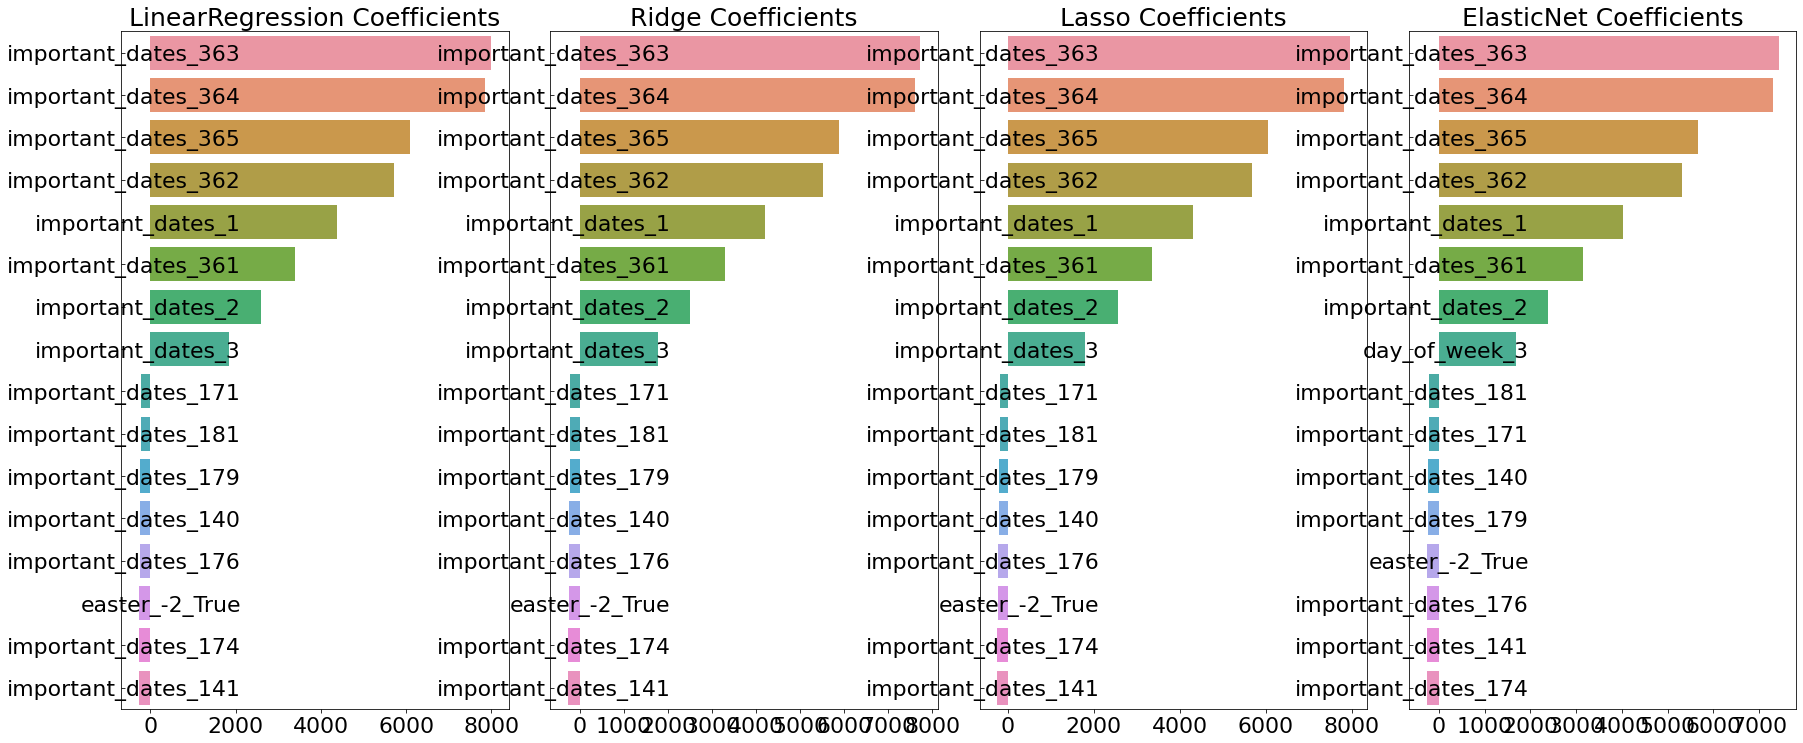

In [61]:
def get_top_bottom_coef(model, n=8):
    coef = pd.Series(model.coef_,index=X.columns)
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

def visualize_coefficient(models):
    fig,axs= plt.subplots(figsize=(24,10),nrows=1,ncols=4)
    fig.tight_layout()
    for i_num, model in enumerate(models):
        coef_high,coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high,coef_low])
        axs[i_num].set_title(model.__class__.__name__+' Coefficients',size=25)
        axs[i_num].tick_params(axis='y',direction="in",pad=-120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values,y=coef_concat.index,ax=axs[i_num])
        
visualize_coefficient(models)

In [62]:
test_all_df_dates

,date,num_sold
0,2021-01-01,14199.591140
1,2021-01-02,14288.436074
2,2021-01-03,13917.411185
3,2021-01-04,11768.947202
4,2021-01-05,11931.884549
...,...,...
360,2021-12-27,13871.888595
361,2021-12-28,15961.932950
362,2021-12-29,18150.585287
363,2021-12-30,18077.103588


In [63]:
product_ratio_2017 = product_ratio_df.loc[product_ratio_df['date'].dt.year == 2017].copy()
product_ratio_2017['mm-dd'] = product_ratio_2017['date'].dt.strftime('%m-%d')
product_ratio_2017 = product_ratio_2017.drop(columns='date')
product_ratio_2017 = product_ratio_2017.reset_index()

In [64]:
product_ratio_2018 = product_ratio_df.loc[product_ratio_df['date'].dt.year == 2018].copy()
product_ratio_2018['mm-dd'] = product_ratio_2018['date'].dt.strftime('%m-%d')
product_ratio_2018 = product_ratio_2018.drop(columns='date')
product_ratio_2018 = product_ratio_2018.reset_index()

In [65]:
product_ratio_2019 = product_ratio_df.loc[product_ratio_df['date'].dt.year == 2019].copy()
product_ratio_2019['mm-dd'] = product_ratio_2019['date'].dt.strftime('%m-%d')
product_ratio_2019 = product_ratio_2019.drop(columns='date')

In [66]:
product_ratio_2019 = product_ratio_2019.reset_index()

In [67]:
product_ratio_2019['mean_ratios'] = (product_ratio_2017['ratios']+product_ratio_2018['ratios']+product_ratio_2019['ratios'])/3
product_ratio_2019

,index,product,ratios,mm-dd,mean_ratios
0,2920,Kaggle_Advanced_Techniques,0.279273,01-01,0.279244
1,2921,Kaggle_Getting_Started,0.230832,01-01,0.227723
2,2922,Kaggle_Recipe_Book,0.188119,01-01,0.189136
3,2923,Kaggle_for_Kids__One_Smart_Goose,0.301776,01-01,0.303897
4,2924,Kaggle_Advanced_Techniques,0.281654,01-02,0.283298
...,...,...,...,...,...
1455,4375,Kaggle_for_Kids__One_Smart_Goose,0.304807,12-30,0.303832
1456,4376,Kaggle_Advanced_Techniques,0.277440,12-31,0.279852
1457,4377,Kaggle_Getting_Started,0.224633,12-31,0.224372
1458,4378,Kaggle_Recipe_Book,0.191453,12-31,0.191381


In [68]:
test_product_ratio_df = test_df.copy()
test_product_ratio_df['mm-dd'] = test_product_ratio_df['date'].dt.strftime('%m-%d')

test_product_ratio_df = pd.merge(test_product_ratio_df,product_ratio_2019, how="left", on = ["mm-dd","product"])
test_product_ratio_df.head()

,row_id,date,country,store,product,mm-dd,index,ratios,mean_ratios
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle_Advanced_Techniques,01-01,2920,0.279273,0.279244
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle_Getting_Started,01-01,2921,0.230832,0.227723
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle_Recipe_Book,01-01,2922,0.188119,0.189136
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle_for_Kids__One_Smart_Goose,01-01,2923,0.301776,0.303897
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle_Advanced_Techniques,01-01,2920,0.279273,0.279244


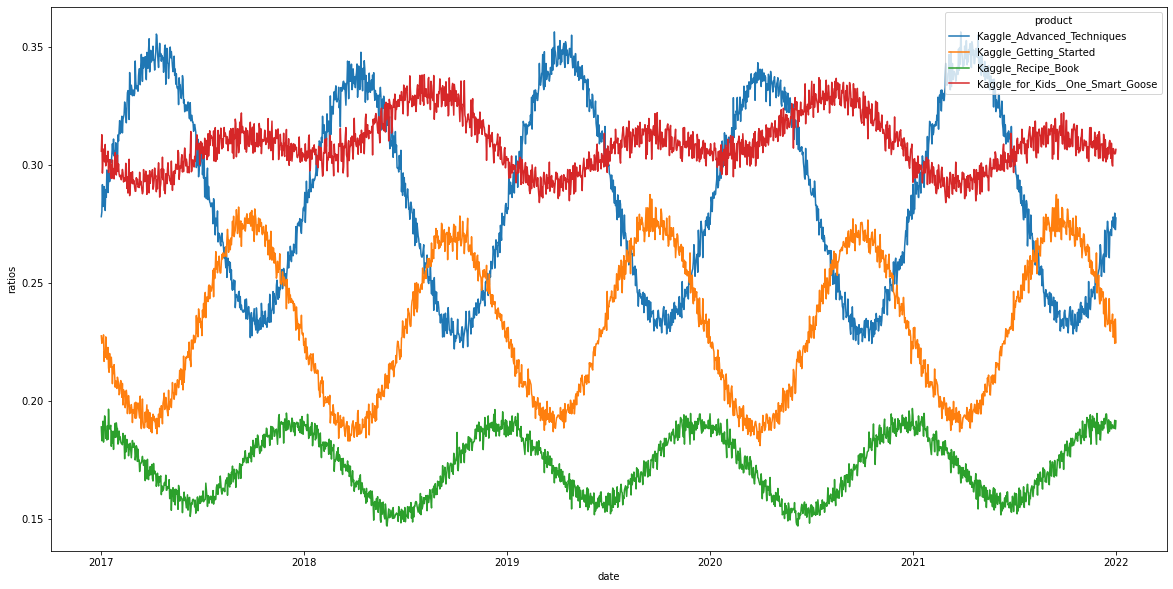

In [69]:
temp_df = pd.concat([product_ratio_df,test_product_ratio_df]).reset_index(drop=True)
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=temp_df, x="date", y="ratios", hue="product");

In [70]:
test_sub_df = pd.merge(test_df, test_all_df_dates, how="left")
test_sub_df["ratios"] = test_product_ratio_df["ratios"]
test_sub_df["mean_ratios"] = test_product_ratio_df["mean_ratios"]
test_sub_df.head()

,row_id,date,country,store,product,num_sold,ratios,mean_ratios
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle_Advanced_Techniques,14199.59114,0.279273,0.279244
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle_Getting_Started,14199.59114,0.230832,0.227723
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle_Recipe_Book,14199.59114,0.188119,0.189136
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle_for_Kids__One_Smart_Goose,14199.59114,0.301776,0.303897
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle_Advanced_Techniques,14199.59114,0.279273,0.279244


In [71]:
original_train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [72]:
store_weights = original_train_df.groupby('store')['num_sold'].sum()/original_train_df['num_sold'].sum()
store_weights

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64

In [73]:
country_weights = original_train_df.groupby('country')['num_sold'].sum()/original_train_df['num_sold'].sum()
country_weights

country
Belgium    0.204104
France     0.184381
Germany    0.204498
Italy      0.161540
Poland     0.098457
Spain      0.147020
Name: num_sold, dtype: float64

In [74]:
def disaggregate_forecast(df) :
    new_df = df.copy()
    
    store_weights = original_train_df.groupby('store')['num_sold'].sum()/original_train_df['num_sold'].sum()
    print(store_weights)
    country_weights = pd.Series(index = test_sub_df["country"].unique(),data = 1/6)
    print(country_weights)
    for country in country_weights.index:
        new_df.loc[(new_df["country"] == country), "num_sold"] = new_df.loc[(new_df["country"] == country), "num_sold"] *  country_weights[country]
    print(new_df)
    for store in store_weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * store_weights[store]
        
    #new_df["num_sold"] = new_df["num_sold"] * new_df["ratios"]
    new_df["num_sold"] = new_df["num_sold"] * new_df["mean_ratios"]
    new_df["num_sold"] = new_df["num_sold"].round()
    new_df = new_df.drop(columns=["ratios"])    
    
    return new_df

In [75]:
final_df = disaggregate_forecast(test_sub_df)
final_df

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64
Belgium    0.166667
France     0.166667
Germany    0.166667
Italy      0.166667
Poland     0.166667
Spain      0.166667
dtype: float64
       row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product     num_sold    ratios  mean_ratios  
0            Kaggle_Advanced_Techniques  2366.598523  0.279273     0.279244  
1                Kaggle_Getting_Start

,row_id,date,country,store,product,num_sold,mean_ratios
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle_Advanced_Techniques,491.0,0.279244
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle_Getting_Started,400.0,0.227723
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle_Recipe_Book,332.0,0.189136
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle_for_Kids__One_Smart_Goose,534.0,0.303897
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle_Advanced_Techniques,170.0,0.279244
...,...,...,...,...,...,...,...
17515,87643,2021-12-31,Spain,KaggleMart,Kaggle_for_Kids__One_Smart_Goose,631.0,0.304394
17516,87644,2021-12-31,Spain,KaggleRama,Kaggle_Advanced_Techniques,201.0,0.279852
17517,87645,2021-12-31,Spain,KaggleRama,Kaggle_Getting_Started,161.0,0.224372
17518,87646,2021-12-31,Spain,KaggleRama,Kaggle_Recipe_Book,138.0,0.191381


In [76]:
submission = pd.read_csv("../submission/sample_submission.csv")
submission["num_sold"] = final_df["num_sold"]

In [77]:
submission.to_csv('submission.csv', index = False)

In [78]:
submission

,row_id,num_sold
0,70128,491.0
1,70129,400.0
2,70130,332.0
3,70131,534.0
4,70132,170.0
...,...,...
17515,87643,631.0
17516,87644,201.0
17517,87645,161.0
17518,87646,138.0
